# Modeling of mock data from VKL paper

In this notebook we interested in fitting simulated lens systems from **Vernados et al. 2021** (in prep.).

Warning: we need to include a uniform light sheet to compensate the sky level, that is not centered to zero, due to the way mocks were generated with `MOLET`. This is included as a `'UNIFORM'` lens light profile.

__last updated__: 04/08/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
import copy
from astropy.io import fits
from pprint import pprint
import pickle as pkl
import time
from matplotlib.colors import LogNorm
plt.rc('image', interpolation='none')

# JAX
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Analysis.plot import Plotter

# Universal font size
FS = 18

# Global settings
max_iterations = 1000
init_learning_rate = 1e-3

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=6e-3, flux_vmax=8e-1)

In [2]:
case_id = 1  # integer between 1 and 5
potential_grid_factor = 4  # warning: some dpsi noise maps have not been computed

### Data grids

In [3]:
base_dir = os.path.join('data', 'VKL/blind_data', f'case_{case_id}')
data = fits.getdata(os.path.join(base_dir, 'image.fits')).astype(float)
data_hdr = fits.getheader(os.path.join(base_dir, 'image.fits'))
psf_kernel_raw = fits.getdata(os.path.join(base_dir, 'psf.fits')).astype(float)
vkl_mask = fits.getdata(os.path.join(base_dir, 'mask.fits')).astype(bool)
background_var = float(np.loadtxt(os.path.join(base_dir, 'noise.dat')))

# inform the plotter
plotter.set_data(data)

npix, npix_y = data.shape
pix_scl = data_hdr['WIDTH'] / npix  # arcsec / pixel
assert pix_scl == data_hdr['HEIGHT'] / npix_y, "non-square pixels?!"
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid for pixelated potential
npix_lowres = npix // potential_grid_factor
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {x_grid[0, 0], x_grid[0, -1]} arcsec")
print(f"y range    : {y_grid[0, 0], y_grid[-1, 0]} arcsec")

# supersampling?
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': 'grid'}

image size : (80, 80) pixels
pixel size : 0.04375 arcsec
x range    : (-1.728125, 1.728125) arcsec
y range    : (-1.728125, 1.728125) arcsec


### Load imaging data

-0.061212338507175446


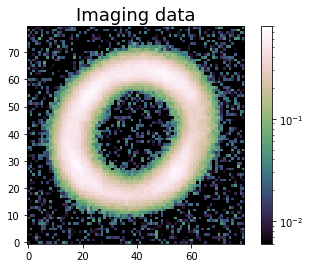

In [4]:
print(data.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plt.colorbar()
plt.show()

### Noise

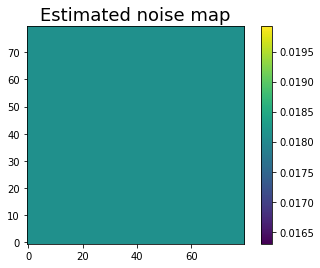

In [5]:
# here we know the true exposure time and background noise level
kwargs_noise = {'background_rms': np.sqrt(background_var), 
                'exposure_time': None}
noise = Noise(npix, npix, **kwargs_noise)
noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
#plt.imshow(np.sqrt(data_class.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

1.4310220421975828e-06 0.18236729502677917


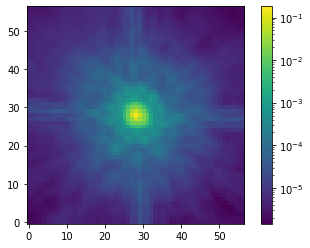

In [6]:
psf_kernel = psf_kernel_raw[8:-9, 9:-8]
print(psf_kernel.min(), psf_kernel.max())
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf = PSF(**kwargs_psf)

plt.imshow(psf.kernel_point_source, origin='lower', norm=LogNorm())
plt.colorbar()
plt.show()

## 1) Analytical lens + analytical smooth source modeling

Here we choose only smooth profile for a first rough model.

### Define modeling choices and initial parameter values

In [7]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

# Lens light
lens_light_model_list = ['UNIFORM']
lens_light_model = LightModel(lens_light_model_list)

# Create the model image
lens_image_allsmooth = LensImage(pixel_grid, psf, noise_class=noise,
                                 lens_model_class=lens_mass_model,
                                 source_model_class=source_light_model,
                                 lens_light_model_class=lens_light_model,
                                 kwargs_numerics=kwargs_numerics)

kwargs_init = {
    'kwargs_lens': [{'theta_E': 1., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'amp': 20., 'R_sersic': 0.5, 'n_sersic': 2., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}],
    'kwargs_lens_light': [{'amp': -1.}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_allsmooth = Parameters(lens_image_allsmooth, kwargs_init, kwargs_prior, kwargs_fixed)
param_names = parameters_allsmooth.names
p_init_allsmooth = parameters_allsmooth.kwargs2args(kwargs_init)
print("truths:", param_names, len(param_names))

print("prior types:", parameters_allsmooth.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_allsmooth.bounds)

truths: ['theta_E', 'e1', 'e2', 'gamma_ext', 'psi_ext', 'amp', 'R_sersic', 'n_sersic', 'e1', 'e2', 'center_x', 'center_y', 'amp'] 13
prior types: [None, None, None, None, None, None, None, None, None, None, None, None, None]
lower/upper bounds (for uniform priors): [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf inf inf inf inf inf]


### Visualise initial model

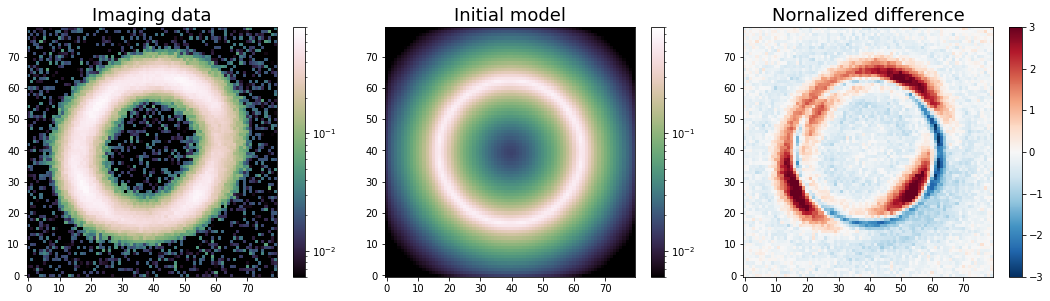

In [8]:
init_model = lens_image_allsmooth.model(**kwargs_init)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Imaging data", fontsize=FS)
img = ax.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[1]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(init_model, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[2]
ax.set_title("Nornalized difference", fontsize=FS)
img = ax.imshow(data/data.mean()-init_model/init_model.mean(), origin='lower', cmap='RdBu_r', vmin=-3, vmax=3)
fig.colorbar(img, ax=ax)
fig.tight_layout()

### Optimize parameters

In [9]:
loss_allsmooth = Loss(data, lens_image_allsmooth, 
                      parameters_allsmooth, likelihood_type='chi2')
optimizer_allsmooth = Optimizer(loss_allsmooth, parameters_allsmooth)
print(f"Initial loss: {loss_allsmooth(p_init_allsmooth):.2f}")

Initial loss: 24.19


In [10]:
# Optimise !
START = time.time()  # time the whole notebook
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_allsmooth.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_allsmooth = parameters_allsmooth.best_fit_values(as_kwargs=True)

Runtime: 6.118693113327026
Final loss: 1.50


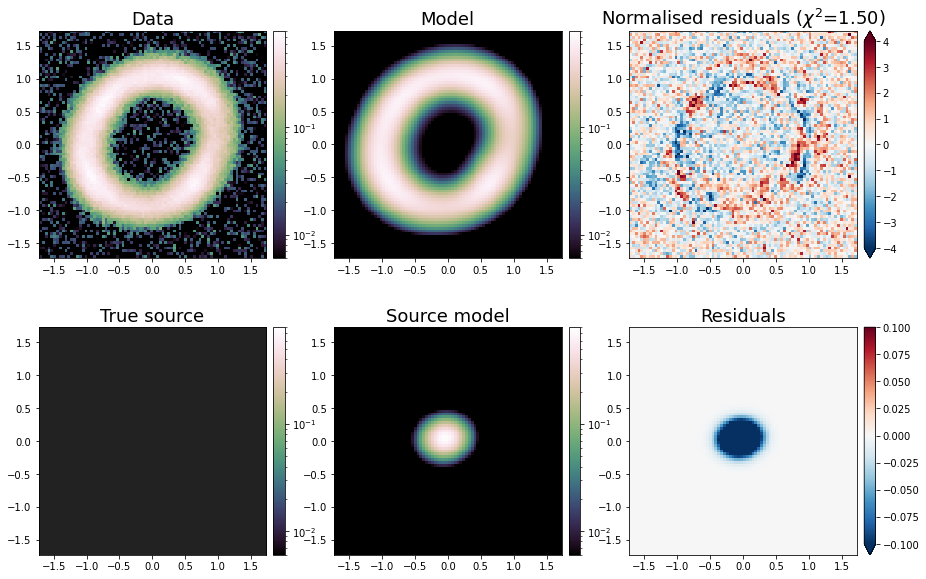

In [11]:
plotter.model_summary(lens_image_allsmooth, kwargs_final_allsmooth)

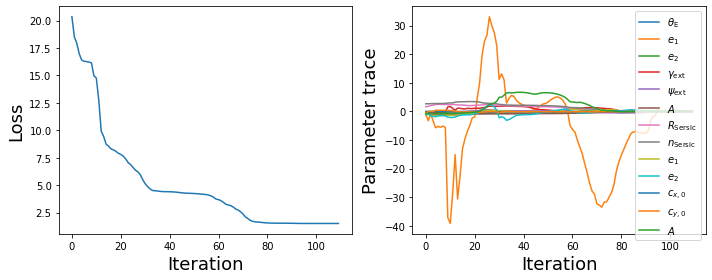

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer_allsmooth.loss_history)), optimizer_allsmooth.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer_allsmooth.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer_allsmooth.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters_allsmooth.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [13]:
pprint(kwargs_final_allsmooth)

{'kwargs_lens': [{'center_x': 0.0,
                  'center_y': 0.0,
                  'e1': DeviceArray(0.00178488, dtype=float64),
                  'e2': DeviceArray(-0.13937423, dtype=float64),
                  'theta_E': DeviceArray(1.00996625, dtype=float64)},
                 {'dec_0': 0.0,
                  'gamma_ext': DeviceArray(-0.02010484, dtype=float64),
                  'psi_ext': DeviceArray(-0.65121858, dtype=float64),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'amp': DeviceArray(-4.09424404, dtype=float64)}],
 'kwargs_source': [{'R_sersic': DeviceArray(0.19126913, dtype=float64),
                    'amp': DeviceArray(186.4160399, dtype=float64),
                    'center_x': DeviceArray(-0.04608575, dtype=float64),
                    'center_y': DeviceArray(0.0446807, dtype=float64),
                    'e1': DeviceArray(0.07723095, dtype=float64),
                    'e2': DeviceArray(0.02443054, dtype=float64),
                    'n_sersic': De

## 2) Pixelated source modeling with fixed smooth lens

Here we optimise the source light on a grid of wavelet-regularized pixels, fixing the lens parameters to their previous values

In [14]:
# Source light
source_light_model_list = ['PIXELATED']
source_light_model = LightModel(source_light_model_list, 
                                pixel_x_coords=x_coords, pixel_y_coords=y_coords,
                                pixel_interpol='bilinear')

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

# Lens light
lens_light_model_list = ['UNIFORM']
lens_light_model = LightModel(lens_light_model_list)

lens_image_pixsource = LensImage(pixel_grid, psf, noise_class=noise,
                                 lens_model_class=lens_mass_model,
                                 source_model_class=source_light_model,
                                 lens_light_model_class=lens_light_model,
                                 kwargs_numerics=kwargs_numerics)

kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'image': 1e-8 * jnp.ones_like(data)}],
    'kwargs_lens_light': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens_light']),
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource = Parameters(lens_image_pixsource, kwargs_init, kwargs_prior, kwargs_fixed)
p_init_pixsource = copy.deepcopy(parameters_pixsource.kwargs2args(kwargs_init))
param_names = parameters_pixsource.names
print(param_names[0], param_names[-1], len(param_names))

print("prior types:", parameters_pixsource.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixsource.bounds)

s_0 amp 6401
prior types: [None, None]
lower/upper bounds (for uniform priors): [-inf -inf] [inf inf]


In [15]:
loss_pixsource = Loss(data, lens_image_pixsource, parameters_pixsource, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source'], 
                      regularization_strengths=[3, 10, 3])
optimizer_pixsource = Optimizer(loss_pixsource, parameters_pixsource)
print(f"Initial loss: {loss_pixsource(p_init_pixsource):.2f}")

Initial loss: 138.51


In [16]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixsource.optax(max_iterations=max_iterations, 
                                init_learning_rate=init_learning_rate,
                                restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_pixsource = parameters_pixsource.best_fit_values(as_kwargs=True)

Runtime: 24.832234144210815 s
Final loss: 1.91


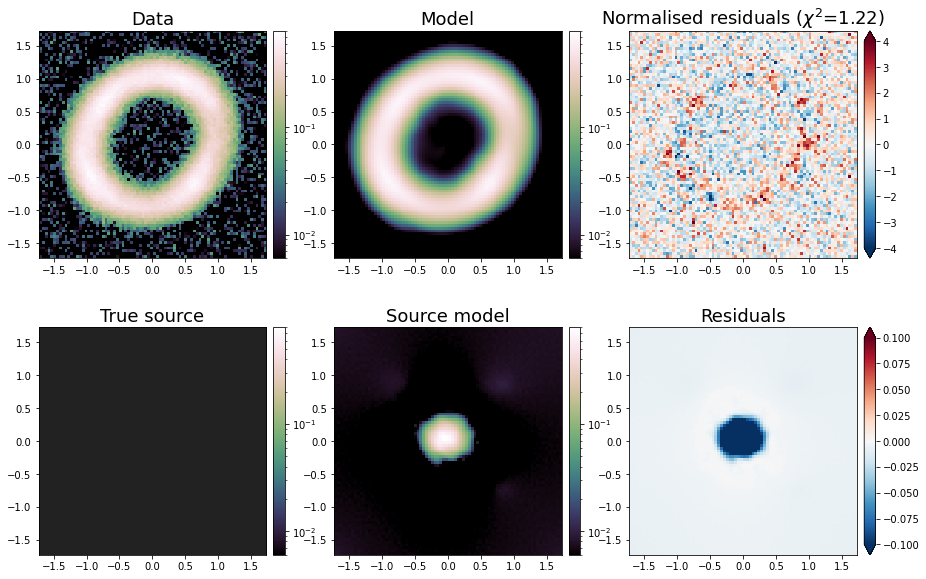

In [17]:
plotter.model_summary(lens_image_pixsource, kwargs_final_pixsource)

In [18]:
pprint(kwargs_final_pixsource['kwargs_lens'])
pprint(kwargs_final_pixsource['kwargs_lens_light'])

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': array(0.00178488),
  'e2': array(-0.13937423),
  'theta_E': array(1.00996625)},
 {'dec_0': 0.0,
  'gamma_ext': array(-0.02010484),
  'psi_ext': array(-0.65121858),
  'ra_0': 0.0}]
[{'amp': DeviceArray(-3.79693253, dtype=float64)}]


## 3) Optimize pixelated source and smooth lens

In [19]:
lens_image_final = copy.deepcopy(lens_image_pixsource)

kwargs_init = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{'image': copy.deepcopy(kwargs_final_pixsource['kwargs_source'][0]['image'])}],
    'kwargs_lens_light': copy.deepcopy(kwargs_final_pixsource['kwargs_lens_light']),
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    #'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_final = Parameters(lens_image_final, kwargs_init, kwargs_prior, kwargs_fixed)
param_names = parameters_final.names
p_init_final = copy.deepcopy(parameters_final.kwargs2args(kwargs_init))
print(param_names[0], param_names[-1], len(p_init_final))

print("prior types:", parameters_final.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_final.bounds)

theta_E amp 6408
prior types: [None, None, None, None, None, None, None, None, None]
lower/upper bounds (for uniform priors): [-inf -inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf inf]


In [20]:
loss_final = Loss(data, lens_image_final, parameters_final, 
                  likelihood_type='l2_norm',
                  regularization_terms=['l1_starlet_source', 
                                        'l1_battle_source',
                                        'positivity_source'],
                  regularization_strengths=[(5, 3), 5, 3]
                 )
optimizer_final = Optimizer(loss_final, parameters_final)
print(f"Initial loss: {loss_final(p_init_final):.2f}")

Initial loss: 1.98


In [21]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_final.optax(max_iterations=max_iterations, 
                            init_learning_rate=init_learning_rate,
                            restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_final = parameters_final.best_fit_values(as_kwargs=True)

Runtime: 22.97406005859375 s
Final loss: 1.92


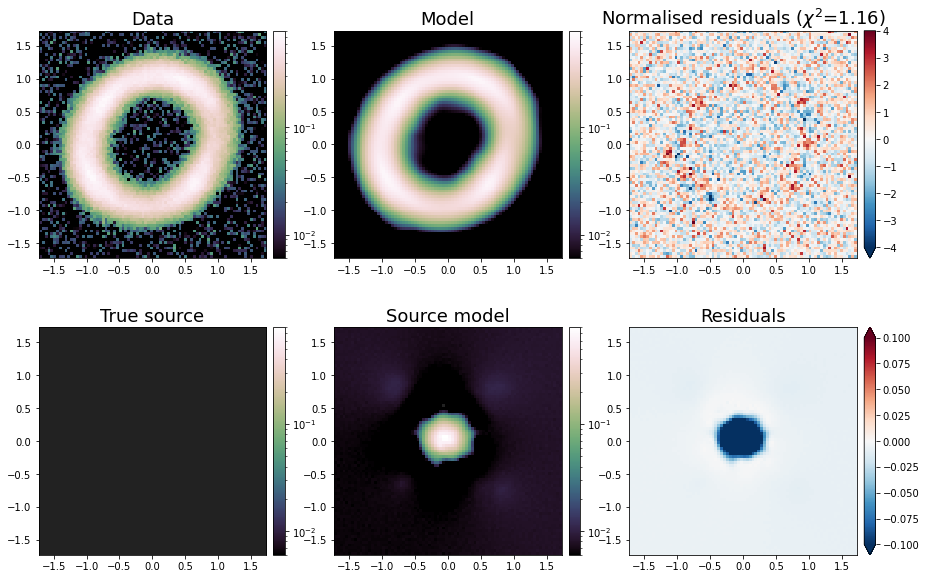

In [22]:
plotter.model_summary(lens_image_final, kwargs_final_final)

In [23]:
pprint(kwargs_final_final['kwargs_lens'])
pprint(kwargs_final_final['kwargs_lens_light'])

[{'center_x': DeviceArray(-0.00529435, dtype=float64),
  'center_y': DeviceArray(0.00549177, dtype=float64),
  'e1': DeviceArray(0.00143914, dtype=float64),
  'e2': DeviceArray(-0.11521645, dtype=float64),
  'theta_E': DeviceArray(1.0072986, dtype=float64)},
 {'dec_0': 0.0,
  'gamma_ext': DeviceArray(-0.02958369, dtype=float64),
  'psi_ext': DeviceArray(-0.70177452, dtype=float64),
  'ra_0': 0.0}]
[{'amp': DeviceArray(-5.76964699, dtype=float64)}]


## 4) Fit remaining residuals with potential perturbations only

In [24]:
# Source light
source_light_model_list = ['PIXELATED']
source_light_model = LightModel(source_light_model_list, 
                                pixel_x_coords=x_coords, pixel_y_coords=y_coords,
                                pixel_interpol='bilinear')

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI', 'PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list, 
                            pixel_x_coords=x_coords_lowres, pixel_y_coords=y_coords_lowres)

# Lens light
lens_light_model_list = ['UNIFORM']
lens_light_model = LightModel(lens_light_model_list)

lens_image_pixpot = LensImage(pixel_grid, psf, noise_class=noise,
                              lens_model_class=lens_mass_model,
                              source_model_class=source_light_model,
                              lens_light_model_class=lens_light_model,
                              kwargs_numerics=kwargs_numerics)

kwargs_init = {
    'kwargs_lens': [{}, {}] + [{'psi_grid': 1e-8 * jnp.ones((npix_lowres, npix_lowres))}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    # here we fix all smooth model parameters to best-fit from previous step
    'kwargs_lens': copy.deepcopy(kwargs_final_final['kwargs_lens']) + [{}],
    'kwargs_source': copy.deepcopy(kwargs_final_final['kwargs_source']),
    'kwargs_lens_light': copy.deepcopy(kwargs_final_final['kwargs_lens_light']),
}
parameters_pixpot = Parameters(lens_image_pixpot, kwargs_init, kwargs_prior, kwargs_fixed)
p_init_pixpot = copy.deepcopy(parameters_pixpot.kwargs2args(kwargs_init))
param_names = parameters_pixpot.names
print(p_init_pixpot[0], param_names[0], param_names[-1], len(p_init_pixpot))

print("prior types:", parameters_pixpot.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixpot.bounds)

1e-08 d_0 d_399 400
prior types: [None]
lower/upper bounds (for uniform priors): [-inf] [inf]


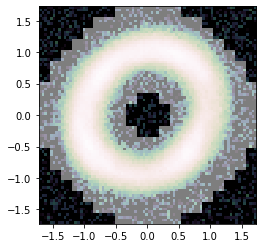

In [25]:
# Generate a mask on low-res grid
rmin = 0.3
rmax = 1.8
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

plt.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux, extent=extent)
plt.imshow(mask_lowres, origin='lower', cmap='gray', alpha=0.5, extent=extent)
plt.show()

In [26]:
# load pre-compute potential noise map
dpsi_noise_map = np.load(f'data/VKL/dpsi_1sigma_vkl_mock_case{case_id}_{npix_lowres}px_fullmass_fullamp.npy')

# compute the mean inside the mask
print(dpsi_noise_map.shape, mask_lowres.shape)
dpsi_noise_map_meanmask = np.mean(dpsi_noise_map[mask_lowres == 1])

# choose the potential noise map
potential_noise_map = dpsi_noise_map_meanmask

loss_pixpot = Loss(data, lens_image_pixpot, parameters_pixpot, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source',
                                            'l1_starlet_potential', 
                                            'l1_battle_potential'], 
                      regularization_strengths=[(5, 3), 3, 3, (10, 10), 30],
                      potential_noise_map=potential_noise_map)

optimizer_pixpot = Optimizer(loss_pixpot, parameters_pixpot)
print(f"Initial loss: {loss_pixpot(p_init_pixpot):.2f}")

(20, 20) (20, 20)
Initial loss: 1.89


In [27]:
use_optax_for_pixpot = True

if use_optax_for_pixpot:
    best_fit, logL_best_fit, extra_fields, runtime \
        = optimizer_pixpot.optax(max_iterations=max_iterations, 
                                 init_learning_rate=init_learning_rate,
                                 restart_from_init=True)
else:
    best_fit, logL_best_fit, extra_fields, runtime \
        = optimizer_pixpot.minimize(method='BFGS', restart_from_init=True)
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    ax = axes
    ax.plot(range(len(optimizer_pixpot.loss_history)), optimizer_pixpot.loss_history)
    ax.set_ylabel("Loss", fontsize=FS)
    ax.set_xlabel("Iteration", fontsize=FS)
    plt.show()
    
END = time.time()
print(f"Runtime: {runtime}")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_pixpot = parameters_pixpot.best_fit_values(as_kwargs=True)

Runtime: 22.860925912857056
Final loss: 1.82


delta_psi shift by mean values: -1.0354518050408684e-05 4.91160598408008e-06


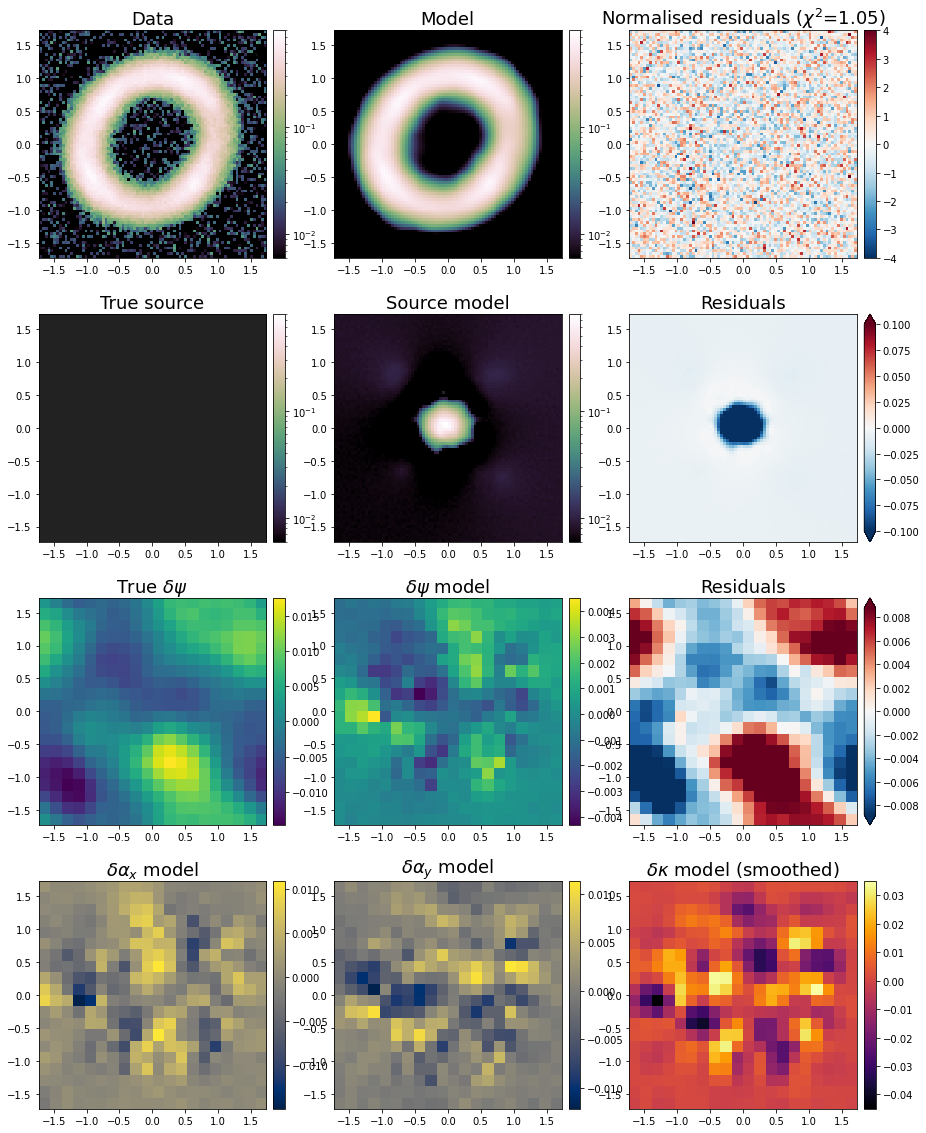

In [28]:
# Get the true (CHECK THIS) perturbations
dpsi_dir = os.path.join('data', 'VKL/blind_data')
dpsi_molet = fits.getdata(os.path.join(dpsi_dir, 'dpsi_molet_example.fits')).astype(float)
# degrade it to lowres
from jaxtronomy.Util import image_util
dpsi_molet_lowres = image_util.re_size_array(x_coords, y_coords, dpsi_molet, x_coords_lowres, y_coords_lowres)

plotter.set_true_potential_perturbations(dpsi_molet_lowres)
plotter.model_summary(lens_image_pixpot, kwargs_final_pixpot,
                      show_lens_mass=True, potential_mask=mask_lowres,
                      with_mask=False, shift_potential='mean')

In [29]:
pprint(kwargs_final_pixpot['kwargs_lens'][:-1])
pprint(kwargs_final_pixpot['kwargs_lens_light'])

[{'center_x': array(-0.00529435),
  'center_y': array(0.00549177),
  'e1': array(0.00143914),
  'e2': array(-0.11521645),
  'theta_E': array(1.0072986)},
 {'dec_0': 0.0,
  'gamma_ext': array(-0.02958369),
  'psi_ext': array(-0.70177452),
  'ra_0': 0.0}]
[{'amp': array(-5.76964699)}]


In [30]:
print(f"Notebook total runtime (including notebook overhead): {(END-START)/60.:.1f} minutes")

Notebook total runtime (including notebook overhead): 1.7 minutes


## 5) Fit everything (very ambitious)